In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

ASSRG Segmentation
---
### "An Adaptive Single Seed Based Region Growing Algorithm for Color Image Segmentation"
Jain & Susan, 2013, DOI:10.1109/INDCON.2013.6725922, [URL](https://www.researchgate.net/publication/260122481_An_adaptive_single_seed_based_region_growing_algorithm_for_color_image_segmentation)

This code shows a simple form of ASSRG segmentation. It has to be noted that working with fixed thresholds (like the thresholds for adding a pixel to a region or merging regions if they are too small) is not suitable for every image.

Image size: 225 x 225


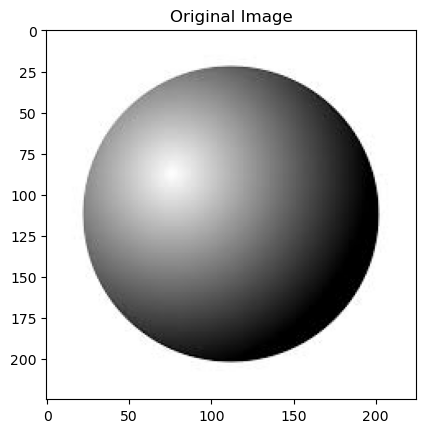

In [16]:
# Load your image
image_path = "/home/lucie/Downloads/sphere.jpeg"  # Change this to your image
I = cv2.imread(image_path)
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
R, C = I.shape[:2]

print(f"Image size: {R} x {C}")
plt.imshow(I)
plt.title('Original Image')
plt.show()

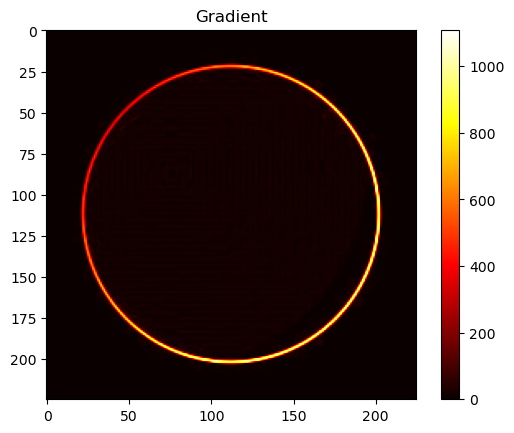

In [17]:
# Find flat areas for good seed placement
gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
gradient = np.sqrt(grad_x**2 + grad_y**2)

plt.imshow(gradient, cmap='hot')
plt.title('Gradient')
plt.colorbar()
plt.show()

# Algorithm Initalization
Here the first seed pixel is set to the one having the lowest gradient in a 50x50 region surrounding the image center. This ensures it is not using a border region pixel.

In [18]:
# Find first seed in low-gradient area near center
# This ensures the seed is not a pattern border region
center_x, center_y = R//2, C//2
search_size = 50
x_start = max(0, center_x - search_size//2)
x_end = min(R, center_x + search_size//2)  
y_start = max(0, center_y - search_size//2)
y_end = min(C, center_y + search_size//2)

center_region = gradient[x_start:x_end, y_start:y_end]
local_min = np.unravel_index(np.argmin(center_region), center_region.shape)
seed_x = x_start + local_min[0]
seed_y = y_start + local_min[1]

print(f"First seed at ({seed_x}, {seed_y})")

# Initialize
labels = np.zeros((R, C), dtype=int)
region_counter = 0
region_means = {}

First seed at (87, 129)


# Helper Functions
Here are some helpful functions for later:

In [19]:
def get_neighbors(x, y):
    """
    Get 8-neighbors of a pixel
    """
    neighbors = []
    
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:  # ensure it's not the pixel itself
                continue
                
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < R and 0 <= ny < C:  # ensure neighbor is not over the images border
                neighbors.append((nx, ny))
                
    return neighbors

def color_distance(pixel1, pixel2):
    """
    Calculate RGB color distance
    """
    return np.sum(np.abs(pixel1.astype(int) - pixel2.astype(int)))

def find_next_seed():
    """
    Find next seed in area with lowest gradient
    """
    unlabeled = labels == 0
    
    if not np.any(unlabeled):  # if all pixels are in a seed region
        return None
    
    # Find lowest gradient from unlabeled pixels
    masked_gradient = gradient.copy()
    masked_gradient[~unlabeled] = np.inf
    
    min_pos = np.unravel_index(np.argmin(masked_gradient), masked_gradient.shape)
    
    if masked_gradient[min_pos] == np.inf:  # cannot be used if there is no region yet
        return None
    
    return min_pos

# Algorithm
Here we see the algorithms heart. In short:

```
Initialize: Find low-gradient seed pixel
For every seed region:
    For every edge pixel of a seed region:
        For every 8 neighbor pixels (if not in region already):
            If similar to whole seed region avg. and current pixel, add to region
                Once iterated all edge pixels, find new low-gradient seed pixel and add to regions
```

Be aware that the strict thresholding of pixel similarities is not fit for every image. Lower Thresholds lead to more segments. Too high values can lead to tiny scattered segments. An intermediate works best.


In [20]:
# Start with first seed
current_seed = (seed_x, seed_y)

while current_seed is not None:
    region_counter += 1
    x, y = current_seed
    
    # Initialize region
    labels[x, y] = region_counter
    region_means[region_counter] = I[x, y].astype(float)
    
    # Grow region
    to_grow = deque([(x, y)])
    
    while to_grow:
        cx, cy = to_grow.popleft()
        
        for nx, ny in get_neighbors(cx, cy):
            if labels[nx, ny] != 0:  # Already labeled
                continue
                
            # Check if pixel can join this region
            center_pixel = I[cx, cy]
            neighbor_pixel = I[nx, ny]
            region_mean = region_means[region_counter]
            
            # Distance thresholds from ASSRG paper
            dist1 = color_distance(neighbor_pixel, center_pixel)
            dist2 = color_distance(neighbor_pixel, region_mean)
            
            if dist1 < 20 and dist2 < 130:  # Simplified thresholds
                # using fixed thresholds might not be accurate! change this in the future
                # Add pixel to region
                labels[nx, ny] = region_counter
                to_grow.append((nx, ny))
                
                # Update region mean
                region_pixels = I[labels == region_counter]
                region_means[region_counter] = np.mean(region_pixels, axis=0)
    
    print(f"Region {region_counter} complete - size: {np.sum(labels == region_counter)}")
    
    # Find next seed
    current_seed = find_next_seed()

print(f"Segmentation complete! Total regions: {region_counter}")

Region 1 complete - size: 10323


KeyboardInterrupt: 

# Region Merging
To avoid a scattered segmentation, the regions are merged to their next-color-closest neighbor region if they're too small. Be aware, this cropping of small regions must be adapted depending on your images. 

In [ ]:
# Merge regions smaller than min_size pixels
# This might also not be accurate
min_size = 5000

regions_to_merge = {}  # Map: small_region -> best_neighbor

for region_id in range(1, region_counter + 1):
    region_size = np.sum(labels == region_id)
    
    if region_size < min_size and region_size > 0:
        # Find best neighbor
        region_pixels = np.where(labels == region_id)
        neighbors = set()
        
        for i in range(len(region_pixels[0])):
            px, py = region_pixels[0][i], region_pixels[1][i]
            for nx, ny in get_neighbors(px, py):
                neighbor_label = labels[nx, ny]
                if neighbor_label != region_id and neighbor_label != 0:
                    neighbors.add(neighbor_label)
        
        if neighbors:
            best_neighbor = None
            min_distance = float('inf')
            
            for neighbor in neighbors:
                if neighbor in region_means:
                    dist = np.sum((region_means[region_id] - region_means[neighbor])**2)
                    if dist < min_distance:
                        min_distance = dist
                        best_neighbor = neighbor
            
            if best_neighbor:
                regions_to_merge[region_id] = best_neighbor

for small_region, target_region in regions_to_merge.items():
    labels[labels == small_region] = target_region
    print(f"Merged region {small_region} into {target_region}")

# Update region means for merged regions
unique_labels = np.unique(labels)
for label in unique_labels:
    if label > 0:  # Skip background
        region_pixels = I[labels == label]
        if len(region_pixels) > 0:
            region_means[label] = np.mean(region_pixels, axis=0)

# Plotting Results
Simple plot showing side by side the original and processed image and then edges on the image.

In [ ]:
# Simple visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(I)
axes[0].set_title('Original')
axes[0].axis('off')

# Segmentation
axes[1].imshow(labels, cmap='nipy_spectral')
axes[1].set_title(f'Segmentation ({unique_labels.size} regions)')
axes[1].axis('off')

# Boundaries
boundaries = np.zeros_like(labels, dtype=bool)
for i in range(1, R-1):
    for j in range(1, C-1):
        if labels[i,j] != labels[i-1,j] or labels[i,j] != labels[i+1,j]:
            boundaries[i,j] = True
        if labels[i,j] != labels[i,j-1] or labels[i,j] != labels[i,j+1]:
            boundaries[i,j] = True

axes[2].imshow(I)
axes[2].imshow(boundaries, alpha=0.3, cmap='Reds')
axes[2].set_title('Boundaries')
axes[2].axis('off')

plt.tight_layout()
plt.show()